# Lucy Locomotion Training

Training Lucy to first stand in place, then walk forward.

**Phase 1: Standing** - Learn to balance and maintain upright posture
**Phase 2: Walking** - Transfer learn to walk forward while staying stable

In [18]:
# Imports
import gymnasium as gym
import torch
import os
import numpy as np
import mujoco
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv, VecMonitor, DummyVecEnv
from stable_baselines3.common.monitor import Monitor, load_results
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import matplotlib.pyplot as plt
from datetime import datetime
import importlib
import sys

from src import helpers
from src.definitions import PROJECT_ROOT

# Clear any cached lucy modules and reimport
for mod_name in list(sys.modules.keys()):
    if 'lucy' in mod_name.lower():
        del sys.modules[mod_name]



from src.lucy_classes_v0 import LucyEnv, LucyStandingWrapper, LucyWalkingWrapper

In [19]:
# Configuration
n_envs = 7
xml_path = os.path.join(PROJECT_ROOT, "animals", "lucy_v0.xml")

print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"MuJoCo version: {mujoco.__version__}")

# Verify Lucy model loads
model = mujoco.MjModel.from_xml_path(xml_path)
data = mujoco.MjData(model)
print(f"Lucy model loaded: {model.nq} qpos dims, {model.nv} qvel dims, {model.nu} actuators")
print(f"Observation space will be: {model.nq - 2 + model.nv} dims (qpos[2:] + qvel)")

PyTorch CUDA available: True
MuJoCo version: 3.4.0
Lucy model loaded: 59 qpos dims, 47 qvel dims, 19 actuators
Observation space will be: 104 dims (qpos[2:] + qvel)


In [20]:
# Test single environment
test_env = LucyEnv(xml_file=xml_path, render_mode=None)
obs, info = test_env.reset()
print(f"Observation shape: {obs.shape}")
print(f"Action space: {test_env.action_space}")

# Take a few random steps
for i in range(5):
    action = test_env.action_space.sample()
    obs, reward, terminated, truncated, info = test_env.step(action)
    print(f"Step {i+1}: reward={reward:.3f}, height={info['chest_height']:.3f}")
    if terminated:
        break

test_env.close()
print("✓ Environment test passed")

Observation shape: (104,)
Action space: Box(-1.0, 1.0, (19,), float32)
Step 1: reward=0.818, height=0.193
Step 2: reward=0.830, height=0.277
Step 3: reward=1.022, height=0.355
Step 4: reward=1.007, height=0.428
Step 5: reward=1.002, height=0.492
✓ Environment test passed


# Phase 1: Standing Training

First, train Lucy to stand upright in place without falling. This teaches:
- Balance and stability
- Appropriate joint positions for standing
- How to use tail and limbs for balance

In [21]:
# Create standing training environment
standing_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
standing_log_dir = f"logs/lucy_standing_{standing_start_time}/"
os.makedirs(standing_log_dir, exist_ok=True)

def make_standing_env():
    """Factory function for standing environment."""
    env = LucyEnv(xml_file=xml_path, render_mode=None)
    env = LucyStandingWrapper(
        env,
        target_height=0.15,
        height_weight=2.0,
        upright_weight=1.0,
        stillness_weight=0.5,
        body_contact_penalty=-1.0,
    )
    return env

# Create vectorized environment
# Using DummyVecEnv for debugging, switch to SubprocVecEnv for speed
standing_vec_env = make_vec_env(
    make_standing_env,
    n_envs=n_envs,
    vec_env_cls=SubprocVecEnv,
    monitor_dir=standing_log_dir,
)
standing_vec_env = VecMonitor(standing_vec_env, standing_log_dir)

print(f"Created {n_envs} parallel standing environments")
print(f"Logging to: {standing_log_dir}")

Created 7 parallel standing environments
Logging to: logs/lucy_standing_2026-01-09_14-03/


c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


In [22]:
# Train standing policy
standing_model = PPO(
    "MlpPolicy",
    standing_vec_env,
    verbose=1,
    device="cpu",
    n_steps=2048,
    batch_size=256,
    n_epochs=10,
    gamma=0.99,
    gae_lambda=0.95,
    clip_range=0.2,
    ent_coef=0.01,  # Encourage exploration
    learning_rate=3e-4,
    policy_kwargs=dict(
        net_arch=dict(pi=[256, 256], vf=[256, 256])  # Larger network for complex body
    ),
)

# Train for standing (shorter since simpler task)
STANDING_TIMESTEPS = 2_000_000
print(f"Training standing policy for {STANDING_TIMESTEPS:,} timesteps...")
standing_model.learn(total_timesteps=STANDING_TIMESTEPS)

Using cpu device
Training standing policy for 2,000,000 timesteps...
------------------------------
| time/              |       |
|    fps             | 2863  |
|    iterations      | 1     |
|    time_elapsed    | 5     |
|    total_timesteps | 14336 |
------------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 2429        |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.053274173 |
|    clip_fraction        | 0.378       |
|    clip_range           | 0.2         |
|    entropy_loss         | -27         |
|    explained_variance   | -0.0128     |
|    learning_rate        | 0.0003      |
|    loss                 | 10.2        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0518     |
|    std                  | 1.01        |


KeyboardInterrupt: 

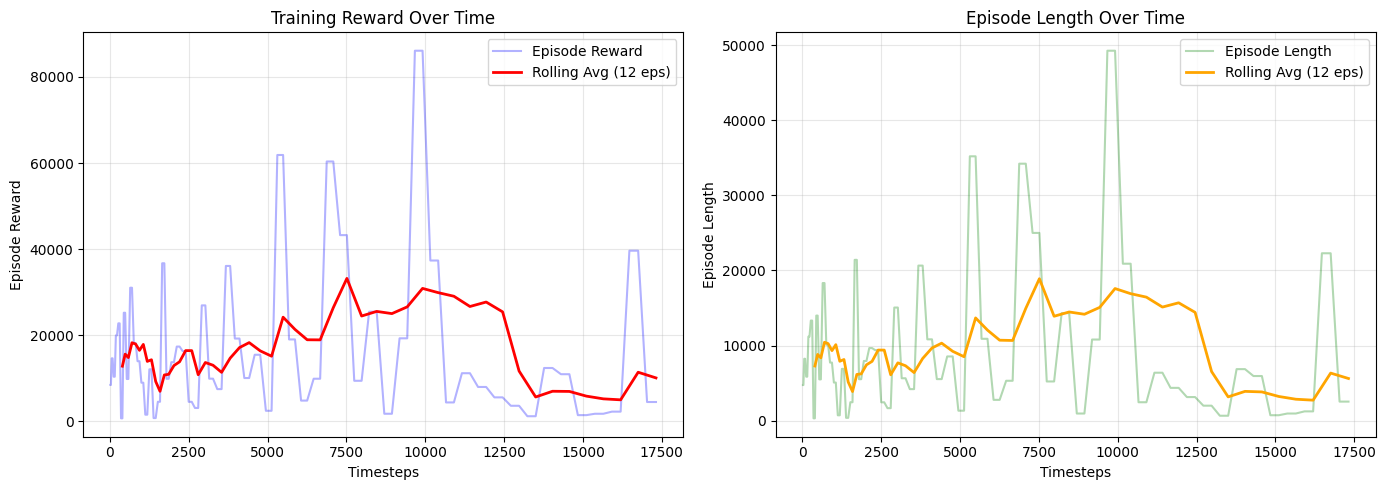


Training Summary:
  Total episodes: 112
  Final avg reward (last 100 eps): 16768.01
  Max reward: 86110.88
  Final avg length (last 100 eps): 9511.0


In [23]:
# Plot standing training progress
importlib.reload(helpers)
standing_df = load_results(standing_log_dir)
helpers.plot_training_progress(standing_df)
helpers.print_training_summary(standing_df)

In [ ]:
# Save standing model
standing_model_name = f"ppo_lucy_standing_{standing_start_time}"
standing_model_path = os.path.join(PROJECT_ROOT, "trained_models", standing_model_name)
standing_model.save(standing_model_path)
standing_vec_env.close()

print(f"Standing model saved to: {standing_model_path}")

Standing model saved to: C:\GitHub\training-lucy\trained_models\ppo_lucy_standing_2026-01-09_12-16


In [ ]:
break

# Phase 2: Walking Training (Transfer Learning)

Now train Lucy to walk forward, starting from the standing policy.
This transfer learning approach:
1. Starts with a policy that already knows how to balance
2. Fine-tunes to add forward motion while maintaining stability

In [ ]:
# Create walking training environment  
walking_start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")
walking_log_dir = f"logs/lucy_walking_{walking_start_time}/"
os.makedirs(walking_log_dir, exist_ok=True)

def make_walking_env():
    """Factory function for walking environment."""
    env = LucyEnv(xml_file=xml_path, render_mode=None)
    env = LucyWalkingWrapper(
        env,
        forward_weight=2.0,
        target_height=0.12,
        height_weight=0.5,
        upright_weight=0.3,
        gait_weight=0.2,
        ctrl_cost_weight=0.001,
        body_contact_penalty=-2.0,
        target_velocity=0.5,
    )
    return env

# Create vectorized environment
walking_vec_env = make_vec_env(
    make_walking_env,
    n_envs=n_envs,
    vec_env_cls=SubprocVecEnv,
    monitor_dir=walking_log_dir,
)
walking_vec_env = VecMonitor(walking_vec_env, walking_log_dir)

print(f"Created {n_envs} parallel walking environments")
print(f"Logging to: {walking_log_dir}")

Created 7 parallel walking environments
Logging to: logs/lucy_walking_2026-01-09_12-33/


c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\vec_env\vec_monitor.py:44: UserWarning: The environment is already wrapped with a `Monitor` wrapperbut you are wrapping it with a `VecMonitor` wrapper, the `Monitor` statistics will beoverwritten by the `VecMonitor` ones.
  warnings.warn(


In [ ]:
# Load standing model and transfer to walking
walking_model = PPO.load(
    standing_model_path,
    env=walking_vec_env,
    device="cpu",
    custom_objects={
        "learning_rate": 1e-4,  # Lower LR for fine-tuning
        "ent_coef": 0.005,  # Less exploration, more exploitation
    }
)

print(f"Loaded standing model from: {standing_model_path}")
print("Starting transfer learning for walking...")

Loaded standing model from: C:\GitHub\training-lucy\trained_models\ppo_lucy_standing_2026-01-09_12-16
Starting transfer learning for walking...


In [ ]:
# Train walking policy (longer since more complex)
WALKING_TIMESTEPS = 6_000_000
print(f"Training walking policy for {WALKING_TIMESTEPS:,} timesteps...")
walking_model.learn(total_timesteps=WALKING_TIMESTEPS)

Training walking policy for 6,000,000 timesteps...
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.06e+03 |
|    ep_rew_mean     | -66.3    |
| time/              |          |
|    fps             | 2876     |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 14336    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.06e+03    |
|    ep_rew_mean          | -66.3       |
| time/                   |             |
|    fps                  | 2396        |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 28672       |
| train/                  |             |
|    approx_kl            | 0.014328269 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -47         |
|    explained_varian

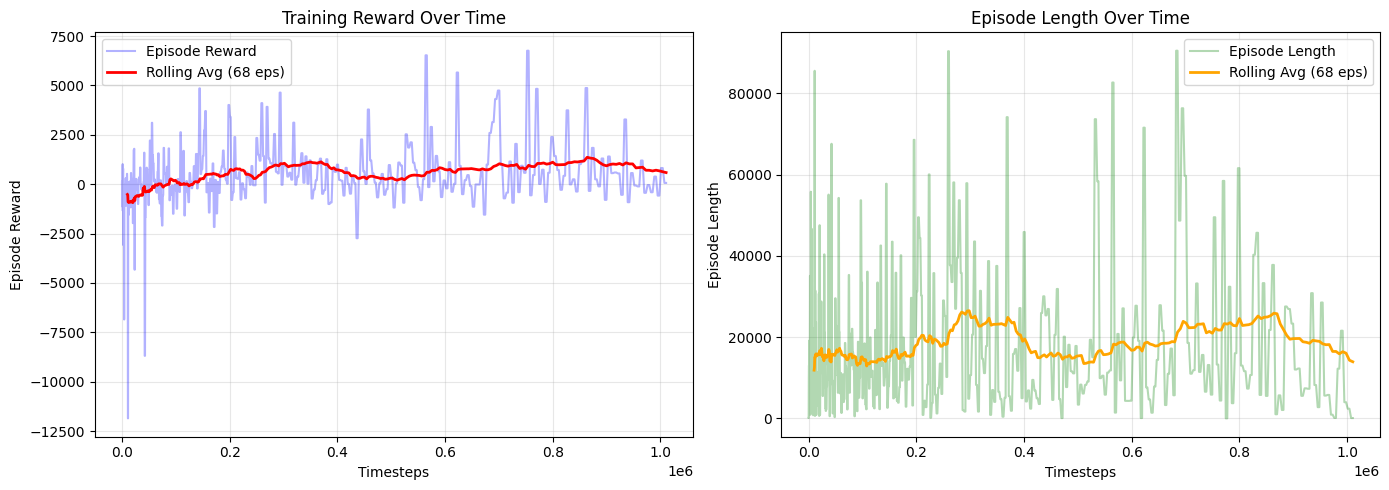


Training Summary:
  Total episodes: 674
  Final avg reward (last 100 eps): 781.76
  Max reward: 6756.86
  Final avg length (last 100 eps): 16258.1


In [ ]:
# Plot walking training progress
walking_df = load_results(walking_log_dir)
helpers.plot_training_progress(walking_df)
helpers.print_training_summary(walking_df)

In [ ]:
# Save walking model
walking_model_name = f"ppo_lucy_walking_{walking_start_time}"
walking_model_path = os.path.join(PROJECT_ROOT, "trained_models", walking_model_name)
walking_model.save(walking_model_path)
walking_vec_env.close()

print(f"Walking model saved to: {walking_model_path}")

Walking model saved to: C:\GitHub\training-lucy\trained_models\ppo_lucy_walking_2026-01-09_12-33


# Evaluation & Visualization

Test the trained policies with rendering

In [ ]:
# Evaluate walking policy with rendering
eval_env = LucyEnv(xml_file=xml_path, render_mode="human")
eval_env = LucyWalkingWrapper(eval_env)

# Load trained model
model_to_eval = PPO.load(walking_model_path)

# Run evaluation episodes
n_eval_episodes = 3
for ep in range(n_eval_episodes):
    obs, info = eval_env.reset()
    total_reward = 0
    step = 0
    
    while True:
        action, _ = model_to_eval.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = eval_env.step(action)
        total_reward += reward
        step += 1
        
        if terminated or truncated or step > 1000:
            print(f"Episode {ep+1}: reward={total_reward:.1f}, steps={step}, x_pos={info['x_position']:.2f}")
            break

eval_env.close()

c:\GitHub\training-lucy\.venv\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


Episode 1: reward=-594.1, steps=1001, x_pos=-4.40
Episode 2: reward=70.3, steps=1001, x_pos=0.85
Episode 3: reward=185.7, steps=1001, x_pos=0.78
